# CIS520 Project
# Part I - Data Processing

### Configure jupyter in Pycharm
http://zhuangzhuang.github.io/2017/01/22/fix-pycharm-jupyter/   
Path of config. file        
/Users/joecao/.jupyter/jupyter_notebook_config.py
### install Ta-lib
* brew ta-lib
* pip install ta-lib
* ref https://mrjbq7.github.io/ta-lib/install.html

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import talib as ta
os.chdir("/Users/joecao/Documents/Upenn/Courses/CIS520/cis520project")  # change root directory
engine = sqlite3.connect('stock_price_DB')

### Notes
    √ missing value checked   
        * amdRaw_df.isnull().any()  
        * googleRaw_df.isnull().any()   
    √ Transferred Date column into datetime type  
    √ Created Features by indicators 
        * using ta-lib and following the built-in function to create ~115 features.   
        * Reference-- https://mrjbq7.github.io/ta-lib/
    √ Removed features with all zero elements
    √ Created a heapmap
    √ Stored raw data and processed data in DB
    ⭕❌❓

In [2]:
amd_raw_df=pd.read_csv('raw_data_amdgoogle/AMD.csv')
google_raw_df=pd.read_csv('raw_data_amdgoogle/GOOGL.csv')
amd_raw_df.columns=['date','open','high','low','close','adj_close','volume']
google_raw_df.columns=['date','open','high','low','close','adj_close','volume']
amd_raw_df['date']=pd.to_datetime(amd_raw_df['date'],format='%Y-%m-%d')
google_raw_df['date']=pd.to_datetime(google_raw_df['date'],format='%Y-%m-%d')

In [3]:
amd_raw_df.to_sql('amd_raw',con=engine,if_exists='replace',index=False)
google_raw_df.to_sql('google_raw',con=engine,if_exists='replace',index=False)

In [4]:
amd_raw_df=pd.read_sql_query('select * from amd_raw', engine)
google_raw_df=pd.read_sql_query('select * from google_raw', engine)
amd_raw_df.head()

,date,open,high,low,close,adj_close,volume
0,2009-05-22 00:00:00,4.43,4.43,4.25,4.26,4.26,8274300
1,2009-05-26 00:00:00,4.26,4.57,4.23,4.53,4.53,16094300
2,2009-05-27 00:00:00,4.57,4.80,4.55,4.71,4.71,21512600
3,2009-05-28 00:00:00,4.75,4.84,4.54,4.70,4.70,18383900
4,2009-05-29 00:00:00,4.71,4.78,4.38,4.54,4.54,24539700


## Creating Features
* `aroon_up` and `arron_dn` -- use 25-day period instead of 14
* `cci` -- use 20-days period instead of 14

In [5]:
def create_features(raw_df):
    processed_df=raw_df.copy()
    #----------- Momentum Indicator Functions
    processed_df['adx']=ta.ADX(raw_df.high, raw_df.low, raw_df.close, timeperiod=14)
    processed_df['adxr'] = ta.ADXR(raw_df.high, raw_df.low, raw_df.close, timeperiod=14)
    processed_df['apo'] = ta.APO(raw_df.close, fastperiod=12, slowperiod=26, matype=0)
    processed_df['aroon_up'],processed_df['aroon_dn']=ta.AROON(raw_df.high, raw_df.low, timeperiod=25)
    processed_df['aroon_osc']=ta.AROONOSC(raw_df.high, raw_df.low, timeperiod=25)
    processed_df['bop'] = ta.BOP(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['cci'] = ta.CCI(raw_df.high, raw_df.low, raw_df.close, timeperiod=20)
    processed_df['cmo'] = ta.CMO(raw_df.close, timeperiod=14)
    processed_df['dx'] = ta.DX(raw_df.high, raw_df.low, raw_df.close, timeperiod=14)
    processed_df['macd'], processed_df['macdsignal'], processed_df['macdhist'] = ta.MACD(raw_df.close, fastperiod=12, slowperiod=26, signalperiod=9)
    processed_df['macd_ext'], processed_df['macdsignal_ext'], processed_df['macdhist_ext'] = ta.MACDEXT(raw_df.close, fastperiod=12, fastmatype=0, slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)
    processed_df['macd_fix'], processed_df['macdsignal_fix'], processed_df['macdhist'] = ta.MACDFIX(raw_df.close, signalperiod=9)
    processed_df['mfi'] = ta.MFI(raw_df.high, raw_df.low, raw_df.close, raw_df.volume, timeperiod=14)
    processed_df['minus_di'] = ta.MINUS_DI(raw_df.high, raw_df.low, raw_df.close, timeperiod=14)
    processed_df['minus_dm'] = ta.MINUS_DM(raw_df.high, raw_df.low, timeperiod=14)
    processed_df['mom'] = ta.MOM(raw_df.close, timeperiod=10)
    processed_df['plus_di'] = ta.PLUS_DI(raw_df.high, raw_df.low, raw_df.close, timeperiod=14)
    processed_df['plus_dm'] = ta.PLUS_DM(raw_df.high, raw_df.low, timeperiod=14)
    processed_df['rpo'] = ta.PPO(raw_df.close, fastperiod=12, slowperiod=26, matype=0)
    processed_df['roc'] = ta.ROC(raw_df.close, timeperiod=10)
    processed_df['rocp'] = ta.ROCP(raw_df.close, timeperiod=10)
    processed_df['rocr'] = ta.ROCR(raw_df.close, timeperiod=10)
    processed_df['rocr100'] = ta.ROCR100(raw_df.close, timeperiod=10)
    processed_df['rsi'] = ta.RSI(raw_df.close, timeperiod=14)
    processed_df['slowk'], processed_df['slowd'] = ta.STOCH(raw_df.high, raw_df.low, raw_df.close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    processed_df['fastk'], processed_df['fastd'] = ta.STOCHF(raw_df.high, raw_df.low, raw_df.close, fastk_period=5, fastd_period=3, fastd_matype=0)
    processed_df['fastk'], processed_df['fastd'] = ta.STOCHRSI(raw_df.close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    processed_df['trix'] = ta.TRIX(raw_df.close, timeperiod=30)
    processed_df['ult_osc'] = ta.ULTOSC(raw_df.high, raw_df.low, raw_df.close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    processed_df['willr'] = ta.WILLR(raw_df.high, raw_df.low, raw_df.close, timeperiod=14)
    # -------------- Volume Indicator Function ---------
    processed_df['ad']=ta.AD(raw_df.high,raw_df.low,raw_df.close,raw_df.volume)
    processed_df['ad_osc'] = ta.ADOSC(raw_df.high,raw_df.low,raw_df.close,raw_df.volume, fastperiod=3, slowperiod=10)
    processed_df['obv']= ta.OBV(raw_df.close, raw_df.volume)
    # --------------- Volatility Indicator Functions ---------
    processed_df['atr'] = ta.ATR(raw_df.high,raw_df.low,raw_df.close, timeperiod=14)
    processed_df['natr'] = ta.NATR(raw_df.high,raw_df.low,raw_df.close, timeperiod=14)
    processed_df['tr']= ta.TRANGE(raw_df.high,raw_df.low,raw_df.close)
    # --------------- Price Transformation Functions -------
    processed_df['avg_price'] = ta.AVGPRICE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['median_price'] = ta.MEDPRICE(raw_df.high, raw_df.low)
    processed_df['typical_price'] = ta.TYPPRICE(raw_df.high, raw_df.low, raw_df.close)
    processed_df['weighted_close_price'] = ta.WCLPRICE(raw_df.high, raw_df.low, raw_df.close)
    # ------------------ Cycle Indicator Functions -------
    processed_df['ht_domint_cycle_period'] = ta.HT_DCPERIOD(raw_df.close)
    processed_df['ht_dominent_cycle_phase'] = ta.HT_DCPHASE(raw_df.close)
    processed_df['ht_phasor_inphase'], processed_df['ht_phasor_quadrature'] = ta.HT_PHASOR(raw_df.close)
    processed_df['ht_sine'], processed_df['ht_leadsine'] = ta.HT_SINE(raw_df.close)
    processed_df['ht_trend_mode'] = ta.HT_TRENDMODE(raw_df.close)
    # ----------------- Statistic Functions -----------
    processed_df['beta'] = ta.BETA(raw_df.high, raw_df.low, timeperiod=5)
    processed_df['corr'] = ta.CORREL(raw_df.high, raw_df.low, timeperiod=30)
    processed_df['linear_reg'] = ta.LINEARREG(raw_df.close, timeperiod=14)
    processed_df['linear_reg_angle'] = ta.LINEARREG_ANGLE(raw_df.close, timeperiod=14)
    processed_df['linear_reg_intercept'] = ta.LINEARREG_INTERCEPT(raw_df.close, timeperiod=14)
    processed_df['linear_reg_slope'] = ta.LINEARREG_SLOPE(raw_df.close, timeperiod=14)
    processed_df['std_dev'] = ta.STDDEV(raw_df.close, timeperiod=5, nbdev=1)
    processed_df['time_series_forecast'] = ta.TSF(raw_df.close, timeperiod=14)
    processed_df['variance'] = ta.VAR(raw_df.close, timeperiod=5, nbdev=1)
    # --------------- Pattern Recognition Functions --------
    processed_df['two_crows'] = ta.CDL2CROWS(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['three_black_crows'] = ta.CDL3BLACKCROWS(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['three_inside'] = ta.CDL3INSIDE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['three_line_strike'] = ta.CDL3LINESTRIKE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['three_outside'] = ta.CDL3OUTSIDE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['three_stars_in_south'] = ta.CDL3STARSINSOUTH(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['three_white_soldiers'] = ta.CDL3WHITESOLDIERS(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['abandoned_baby'] = ta.CDLABANDONEDBABY(raw_df.open, raw_df.high, raw_df.low, raw_df.close, penetration=0)
    processed_df['advance_block'] = ta.CDLADVANCEBLOCK(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['belt_hold'] = ta.CDLBELTHOLD(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['break_away'] = ta.CDLBREAKAWAY(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['closing_marubozu'] = ta.CDLCLOSINGMARUBOZU(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['concealing_baby_swallow'] = ta.CDLCONCEALBABYSWALL(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['counter_attack'] = ta.CDLCOUNTERATTACK(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['dark_cloud_cover'] = ta.CDLDARKCLOUDCOVER(raw_df.open, raw_df.high, raw_df.low, raw_df.close, penetration=0)
    processed_df['doji'] = ta.CDLDOJI(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['doji_star'] = ta.CDLDOJISTAR(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['dragonfly_doji'] = ta.CDLDRAGONFLYDOJI(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['engulfing'] = ta.CDLENGULFING(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['evening_doji_star'] = ta.CDLEVENINGDOJISTAR(raw_df.open, raw_df.high, raw_df.low, raw_df.close, penetration=0)
    processed_df['evening_star'] = ta.CDLEVENINGSTAR(raw_df.open, raw_df.high, raw_df.low, raw_df.close, penetration=0)
    processed_df['gap_side2_white'] = ta.CDLGAPSIDESIDEWHITE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['gravestone_doji'] = ta.CDLGRAVESTONEDOJI(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['hammer'] = ta.CDLHAMMER(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['hanging_man'] = ta.CDLHANGINGMAN(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['harami'] = ta.CDLHARAMI(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['harami_cross'] = ta.CDLHARAMICROSS(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['high_wave'] = ta.CDLHIGHWAVE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['hikkake_pattern'] = ta.CDLHIKKAKE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['hikkake_mod'] = ta.CDLHIKKAKEMOD(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['homing_pigeon'] = ta.CDLHOMINGPIGEON(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['identical_three_crows'] = ta.CDLIDENTICAL3CROWS(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['in_nect'] = ta.CDLINNECK(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['inverted_hammer'] = ta.CDLINVERTEDHAMMER(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['kicking'] = ta.CDLKICKING(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['kicking_by_length'] = ta.CDLKICKINGBYLENGTH(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['ladder_bottom'] = ta.CDLLADDERBOTTOM(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['long_legged_doji'] = ta.CDLLONGLEGGEDDOJI(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['long_line_candle'] = ta.CDLLONGLINE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['marubozu'] = ta.CDLMARUBOZU(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['matching_low'] = ta.CDLMATCHINGLOW(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['mat_hold'] = ta.CDLMATHOLD(raw_df.open, raw_df.high, raw_df.low, raw_df.close, penetration=0)
    processed_df['morning_doji_star'] = ta.CDLMORNINGDOJISTAR(raw_df.open, raw_df.high, raw_df.low, raw_df.close, penetration=0)
    processed_df['morning_star'] = ta.CDLMORNINGSTAR(raw_df.open, raw_df.high, raw_df.low, raw_df.close, penetration=0)
    processed_df['on_neck'] = ta.CDLONNECK(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['piercing'] = ta.CDLPIERCING(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['rickshaw_man'] = ta.CDLRICKSHAWMAN(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['rising_fall_3methods'] = ta.CDLRISEFALL3METHODS(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['separating_lines'] = ta.CDLSEPARATINGLINES(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['shooting_star'] = ta.CDLSHOOTINGSTAR(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['short_line'] = ta.CDLSHORTLINE(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['spinning_top'] = ta.CDLSPINNINGTOP(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['stalled_pattern'] = ta.CDLSTALLEDPATTERN(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['stick_sandwich'] = ta.CDLSTICKSANDWICH(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['takuri'] = ta.CDLTAKURI(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['tasuki_gap'] = ta.CDLTASUKIGAP(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['thrusting'] = ta.CDLTHRUSTING(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['tri_star'] = ta.CDLTRISTAR(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['unique_three_river'] = ta.CDLUNIQUE3RIVER(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['upside_gap_two_crows'] = ta.CDLUPSIDEGAP2CROWS(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['xside_three_methods'] = ta.CDLXSIDEGAP3METHODS(raw_df.open, raw_df.high, raw_df.low, raw_df.close)
    processed_df['trend']=np.sign(raw_df.close.shift(-1)-raw_df.close)
    return processed_df


In [6]:
def drop_all_zero_cols(df):
    ''' drop columns with all elements are zero
    input: dataframe
    output: processed dataframe
    '''
    cols_zero_min=df.columns[df.min()==0]
    temp_df=df[cols_zero_min]
    cols_zero_min_zero_max=temp_df.columns[temp_df.max()==0]
#     print('columns with all zeros are',cols_zero_min_zero_max)
    return df.drop(columns=cols_zero_min_zero_max)

### Drop columns with all zero
**Notes**
* all zero columns in AMD dataset     
    -- ['three_black_crows', 'three_stars_in_south', 'abandoned_baby', 'concealing_baby_swallow', 'kicking', 'kicking_by_length', 'mat_hold', 'rising_fall_3methods', 'upside_gap_two_crows']   (9 cols)
* all zero columns in GOOGLE dataset    
    -- ['three_black_crows', 'three_stars_in_south', 'three_white_soldiers', 'abandoned_baby', 'break_away', 'concealing_baby_swallow', 'identical_three_crows', 'kicking', 'kicking_by_length', 'mat_hold']    (8 cols)

In [7]:
amd_df=create_features(amd_raw_df)
google_df=create_features(google_raw_df)
amd_df=drop_all_zero_cols(amd_df)
google_df=drop_all_zero_cols(google_df)

In [8]:
amd_df.to_sql('amd',con=engine,if_exists='replace',index=False)
google_df.to_sql('google',con=engine,if_exists='replace',index=False)

<Figure size 432x288 with 0 Axes>

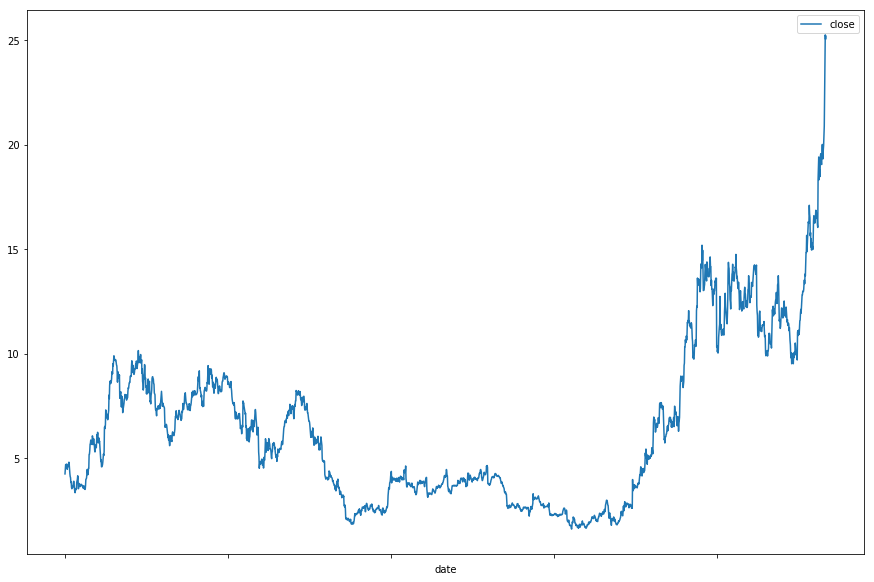

In [9]:
fig=plt.figure()
amd_df.plot(x='date', y=['close'],figsize=(15,10))

### Heat Map

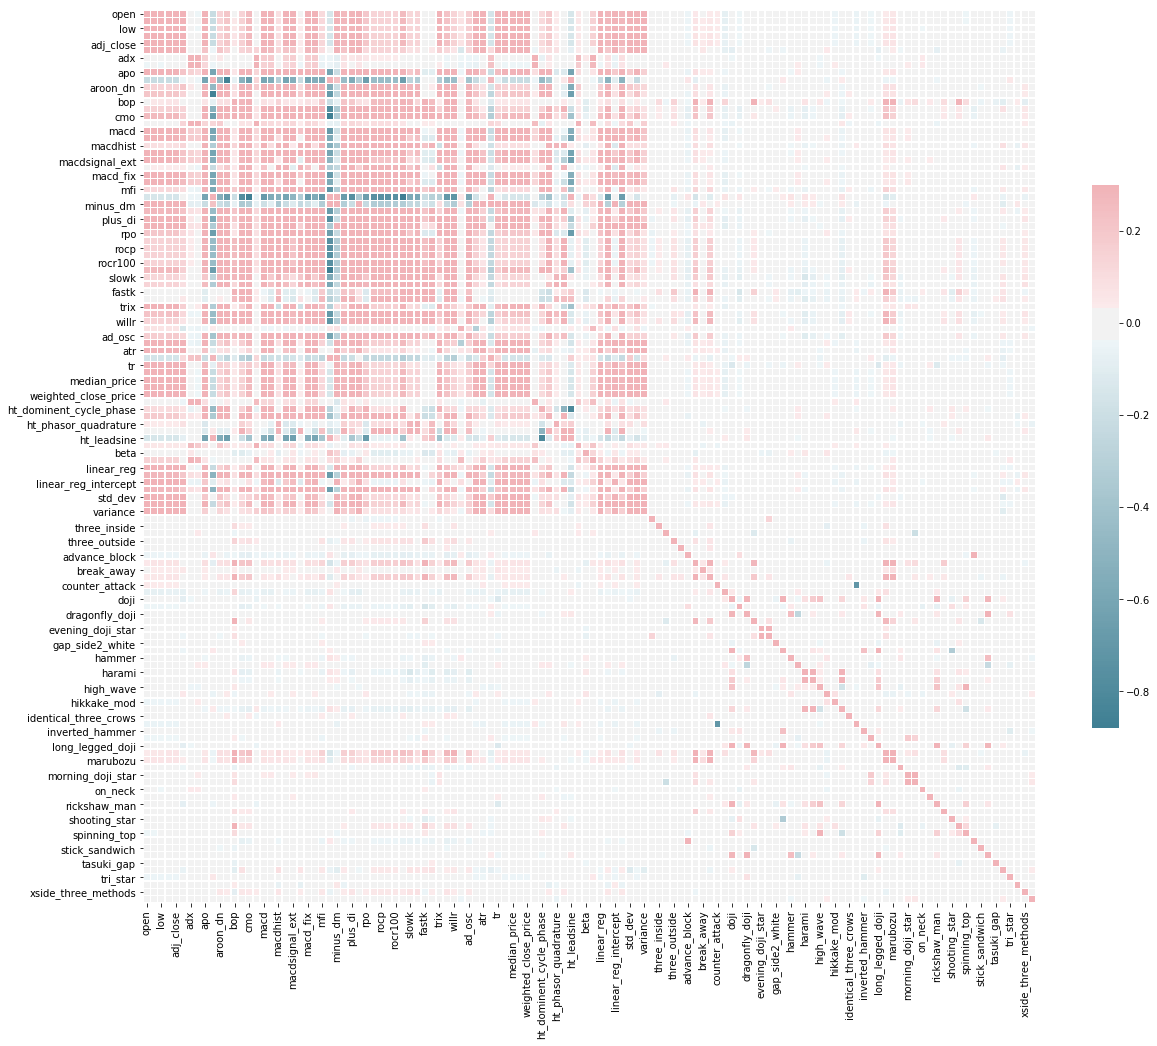

In [12]:
corr_amd=amd_df.drop(columns='date').corr()
corr_google=google_df.drop(columns='date').corr()
# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_amd, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# reference https://seaborn.pydata.org/examples/many_pairwise_correlations.html

In [13]:
corr_amd

,open,high,low,close,adj_close,volume,adx,adxr,apo,aroon_up,...,spinning_top,stalled_pattern,stick_sandwich,takuri,tasuki_gap,thrusting,tri_star,unique_three_river,xside_three_methods,trend
open,1.000000,0.999364,0.999352,0.998658,0.998658,0.579491,-0.030538,-0.037443,0.326193,-0.214101,...,-0.037975,-0.020332,-0.016545,-0.011855,-0.000254,-0.028192,-0.046938,0.018192,0.000090,0.011632
high,0.999364,1.000000,0.999261,0.999427,0.999427,0.590739,-0.028369,-0.035472,0.328790,-0.214445,...,-0.036868,-0.020413,-0.017432,-0.014812,-0.001543,-0.031887,-0.047080,0.018659,-0.001660,0.011550
low,0.999352,0.999261,1.000000,0.999423,0.999423,0.569752,-0.032065,-0.038672,0.326209,-0.217527,...,-0.035824,-0.021729,-0.017089,-0.012440,-0.001032,-0.029453,-0.047766,0.019490,-0.001337,0.010910
close,0.998658,0.999427,0.999423,1.000000,1.000000,0.579457,-0.029946,-0.036713,0.328594,-0.217297,...,-0.034800,-0.021221,-0.018003,-0.011896,-0.002369,-0.033607,-0.046877,0.019619,-0.003121,0.011026
adj_close,0.998658,0.999427,0.999423,1.000000,1.000000,0.579457,-0.029946,-0.036713,0.328594,-0.217297,...,-0.034800,-0.021221,-0.018003,-0.011896,-0.002369,-0.033607,-0.046877,0.019619,-0.003121,0.011026
volume,0.579491,0.590739,0.569752,0.579457,0.579457,1.000000,-0.001319,-0.035489,0.215665,-0.044270,...,-0.013923,0.001527,-0.014981,-0.031347,-0.004978,-0.056260,-0.026700,0.008586,-0.016258,0.011425
adx,-0.030538,-0.028369,-0.032065,-0.029946,-0.029946,-0.001319,1.000000,0.894638,0.150564,0.003496,...,-0.020662,0.005962,-0.016092,-0.015741,0.023377,-0.032150,0.011559,0.021569,0.017341,-0.025191
adxr,-0.037443,-0.035472,-0.038672,-0.036713,-0.036713,-0.035489,0.894638,1.000000,0.115921,-0.049723,...,-0.023360,0.013185,0.002299,-0.008139,0.021133,-0.029715,0.017892,0.026962,0.002621,-0.021670
apo,0.326193,0.328790,0.326209,0.328594,0.328594,0.215665,0.150564,0.115921,1.000000,-0.609274,...,0.006869,-0.024907,-0.008878,-0.029624,-0.007658,0.004734,-0.012442,-0.023451,0.028494,0.006231
aroon_up,-0.214101,-0.214445,-0.217527,-0.217297,-0.217297,-0.044270,0.003496,-0.049723,-0.609274,1.000000,...,-0.036545,0.017812,0.007888,0.016023,0.018971,-0.029513,0.052100,0.027932,-0.021833,-0.003901
